<a href="https://colab.research.google.com/github/NgThanhNhanf/NLP/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install torch==2.3.1 torchtext==0.18.0 portalocker

In [22]:
%cd /content/
!git clone  https://github.com/NgThanhNhanf/NLP.git

/content
fatal: destination path 'NLP' already exists and is not an empty directory.


In [23]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 137.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [24]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 15.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


After downloading, you can re-run the initialization cell (`b2bf295b`) to confirm that Spacy loads the models correctly.

In [25]:
%cd /content/NLP

/content/NLP


In [26]:
!pip install -r requirements.txt

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from src.model_base import Encoder, Decoder, Seq2Seq
from src.dataset import get_data_loaders, build_vocab_and_tokenizers

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Thiết bị đang sử dụng: {device}')

Thiết bị đang sử dụng: cuda


In [49]:
print("Đang xử lý dữ liệu...")

# 1. Đường dẫn file (Đảm bảo bạn đã đổi tên file thành test.en, test.fr như mình dặn)
SRC_FILE = 'data/raw/train.en'
TRG_FILE = 'data/raw/train.fr' # Hoặc tương tự cho Val/Test

# 2. Xây dựng Vocab & Tokenizer (Gọi hàm từ dataset.py của bạn)
# Lưu ý: Bạn cần chỉnh sửa dòng này cho khớp với tên hàm bạn viết trong src/dataset.py
# Mục tiêu là lấy được object vocab để biết kích thước input/output

# 3. Tạo Iterators (DataLoaders)
BATCH_SIZE = 32 # Đề bài gợi ý 32-128
src_vocab, trg_vocab, train_iterator, valid_iterator, test_iterator = get_data_loaders(batch_size=BATCH_SIZE)

print(f"Số lượng câu Train: {len(train_iterator) * BATCH_SIZE}")
print(f"Kích thước từ điển Anh: {len(src_vocab)}")
print(f"Kích thước từ điển Pháp: {len(trg_vocab)}")

Đang xử lý dữ liệu...
Đang xây dựng từ điển (Vocabulary)...
Đang tạo Dataset...
Đang tạo DataLoader...
Số lượng câu Train: 29024
Kích thước từ điển Anh: 6191
Kích thước từ điển Pháp: 6555


In [50]:
# --- HYPERPARAMETERS ---
INPUT_DIM = 10004
OUTPUT_DIM = 10004
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# --- KHỞI TẠO ---
enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

# --- KHỞI TẠO TRỌNG SỐ (WEIGHTS) ---
# Giúp model học nhanh hơn thay vì để random mặc định
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

# Đếm số lượng tham số (Để ghi vào báo cáo cho oách)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Mô hình có {count_parameters(model):,} tham số có thể huấn luyện')

Mô hình có 24,829,716 tham số có thể huấn luyện


In [51]:
optimizer = optim.Adam(model.parameters())

# Bỏ qua padding token khi tính loss
TRG_PAD_IDX = trg_vocab['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [79]:
def train(model, train_loader, val_loader, criterion, optimizer,
                        num_epochs, device, clip=1.0, teacher_forcing_ratio=0.5,
                        patience=3, model_path='best_model.pth'):

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    print(f"🚀 Bắt đầu training với {num_epochs} epochs")
    print(f"   Teacher forcing ratio: {teacher_forcing_ratio}")
    print(f"   Gradient clip: {clip}")
    print(f"   Early stopping patience: {patience}")
    print("=" * 60)

    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()
        epoch_train_loss = 0
        batch_count = 0

        # Thêm progress bar đơn giản
        print(f"\nEpoch {epoch+1}/{num_epochs} - Training...")

        for batch_idx, (source, target) in enumerate(train_loader):
            source, target = source.to(device), target.to(device)
            source_lengths = source_lengths.to(device)

            optimizer.zero_grad()

            # Forward với teacher forcing
            output = model(source, target, source_lengths, teacher_forcing_ratio)

            # Tính loss (bỏ <sos> token)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            target = target[:, 1:].reshape(-1)

            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping với tham số
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

            optimizer.step()

            epoch_train_loss += loss.item()
            batch_count += 1

            # In progress mỗi 50 batch
            if batch_idx % 50 == 0:
                print(f"   Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / batch_count
        train_losses.append(avg_train_loss)

        # === VALIDATION PHASE ===
        print(f"Epoch {epoch+1}/{num_epochs} - Validating...")
        model.eval()
        epoch_val_loss = 0
        batch_count_val = 0

        with torch.no_grad():
            for source, target, source_lengths, _ in val_loader:
                source, target = source.to(device), target.to(device)

                # Evaluation: teacher forcing = 0
                output = model(source, target, source_lengths, teacher_forcing_ratio=0)

                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                target = target[:, 1:].reshape(-1)

                loss = criterion(output, target)
                epoch_val_loss += loss.item()
                batch_count_val += 1

        avg_val_loss = epoch_val_loss / batch_count_val
        val_losses.append(avg_val_loss)

        # === IN KẾT QUẢ ===
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        print(f"   Val Loss:   {avg_val_loss:.4f}")
        print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # === EARLY STOPPING & SAVE BEST MODEL ===
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, model_path)
            print(f"   💾 Best model saved! (Loss: {avg_val_loss:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{patience})")

            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
                print(f"   Best validation loss: {best_val_loss:.4f}")
                break

        print("-" * 60)

    print(f"\n🎉 Training completed!")
    print(f"   Best validation loss: {best_val_loss:.4f}")
    print(f"   Total epochs trained: {len(train_losses)}")

    return train_losses, val_losses

# def evaluate(model, data_loader, criterion, device, teacher_forcing_ratio=0):
#     model.eval()
#     total_loss = 0
#     total_tokens = 0

#     with torch.no_grad():
#         for source, target, source_lengths, target_lengths in data_loader:
#             source, target = source.to(device), target.to(device)

#             output = model(source, target, source_lengths, teacher_forcing_ratio)

#             output_dim = output.shape[-1]
#             output = output[:, 1:].reshape(-1, output_dim)
#             target = target[:, 1:].reshape(-1)

#             loss = criterion(output, target)
#             total_loss += loss.item()

#             # Đếm số token không phải padding để tính perplexity sau này
#             non_pad_tokens = (target != 0).sum().item()
#             total_tokens += non_pad_tokens

#     avg_loss = total_loss / len(data_loader)
#     perplexity = torch.exp(torch.tensor(avg_loss)).item()  # Tính perplexity

#     return avg_loss, perplexity, total_tokens

# # Hàm tính thời gian
# def epoch_time(start_time, end_time):
#     elapsed_time = end_time - start_time
#     elapsed_mins = int(elapsed_time / 60)
#     elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
#     return elapsed_mins, elapsed_secs

In [81]:
N_EPOCHS = 10 # Train 10 vòng
CLIP = 1

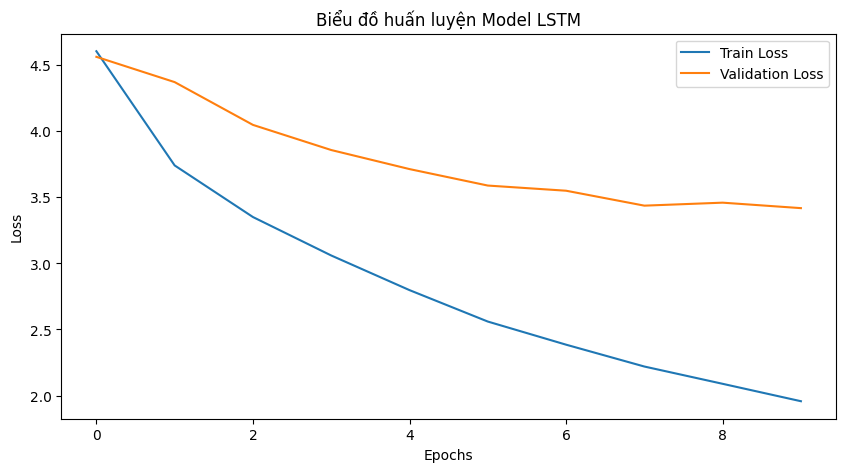

In [ ]:
# Vẽ biểu đồ Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Biểu đồ huấn luyện Model LSTM')
plt.savefig('loss_chart.png') # Lưu ảnh
plt.show()

In [ ]:
# --- ĐOẠN CODE VÁ LỖI ---
from src.dataset import TranslationDataset, build_vocab_and_tokenizers

# 1. Lấy lại bộ từ điển và tokenizer
src_vocab, trg_vocab, src_tokenizer, trg_tokenizer = build_vocab_and_tokenizers()

# 2. Khởi tạo lại biến test_dataset thủ công
print("Đang tải lại tập Test để lấy ví dụ...")
test_dataset = TranslationDataset(
    'data/raw/test_2016_flickr.en',
    'data/raw/test_2016_flickr.fr',
    src_vocab, trg_vocab, src_tokenizer, trg_tokenizer
)

print(f"--> Đã tải xong test_dataset với {len(test_dataset)} câu.")
# Load model tốt nhất
model.load_state_dict(torch.load('best_model.pth'))

# Hàm dịch (Cần chỉnh sửa tùy vào cách bạn tokenize)
def translate_sentence(sentence, src_tokenizer, model, device, max_len=50):
    model.eval()

    # 1. Tokenize
    if isinstance(sentence, str):
        tokens = src_tokenizer(sentence)
    else:
        tokens = sentence

    # 2. Convert to Index
    src_indexes = [src_vocab[token] for token in tokens]
    # Thêm <sos> và <eos>
    src_indexes = [src_vocab['<sos>']] + src_indexes + [src_vocab['<eos>']]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # 3. Qua Encoder
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    # 4. Qua Decoder từng bước
    trg_indexes = [trg_vocab['<sos>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break

    # 5. Convert Index to String
    trg_tokens = [trg_vocab.lookup_token(i) for i in trg_indexes]

    return trg_tokens[1:-1] # Bỏ <sos> và <eos>

# Thử dịch 1 câu trong tập test
# --- SỬA LẠI ĐOẠN LẤY VÍ DỤ ---

# 1. Chọn index
example_idx = 10

# 2. Lấy trực tiếp từ list chứa text thô (Raw text)
# Lưu ý: Class TranslationDataset mình đưa bạn lưu text trong biến .src_data
src = test_dataset.src_data[example_idx].strip()
trg = test_dataset.trg_data[example_idx].strip()

print(f'Src: {src}')
print(f'Trg: {trg}')

# 3. Dịch
# Hàm translate_sentence nhận vào chuỗi string, nên đưa thẳng src vào
translation = translate_sentence(src, src_tokenizer, model, device)

print(f'Pred: {" ".join(translation)}')

Đang xây dựng từ điển (Vocabulary)...
Đang tải lại tập Test để lấy ví dụ...
--> Đã tải xong test_dataset với 1000 câu.
Src: A mother and her young song enjoying a beautiful day outside.
Trg: Une mère et son jeune fils profitant d'une belle journée dehors.
Pred: Une mère et son enfant époux profitant d' une journée par une belle journée .


In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, model, device, max_len=50):
    trgs = []
    pred_trgs = []

    # data ở đây chính là test_dataset
    # Chúng ta lặp qua từng câu trong danh sách src_data
    for i in range(len(data)):

        # 1. Lấy dữ liệu thô (Raw text) từ dataset của chúng ta
        src_raw = data.src_data[i].strip()
        trg_raw = data.trg_data[i].strip()

        # 2. Dịch (Model dự đoán)
        # Hàm translate_sentence trả về list các token
        pred_trg = translate_sentence(src_raw, src_tokenizer, model, device, max_len)

        # 3. Xử lý câu Target (Đáp án chuẩn)
        # Vì BLEU so sánh list token, ta cần tokenize câu đáp án ra
        # (Gọi hàm tokenize_fr mà ta đã khai báo từ đầu)
        trg_tokenized = tokenize_fr(trg_raw)

        # 4. Lưu vào list
        pred_trgs.append(pred_trg)
        trgs.append([trg_tokenized]) # BLEU yêu cầu list of list (vì 1 câu có thể có nhiều cách dịch)

    return bleu_score(pred_trgs, trgs)

# --- CHẠY TÍNH ĐIỂM ---
print("Đang tính BLEU score (sẽ mất khoảng 1-2 phút)...")
score = calculate_bleu(test_dataset, model, device)
print(f'BLEU score = {score*100:.2f}')

Đang tính BLEU score (sẽ mất khoảng 1-2 phút)...
BLEU score = 28.68
